In [33]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr       

from dask.diagnostics import ProgressBar
import seaborn as sns

from scipy import stats
import datetime

import healpix_utils

from matplotlib import colormaps
cmap = colormaps["Set2"]


In [37]:
from scipy.constants import sigma as SB_sigma

def BT_from_OLR(OLR):
    # compute brightness temperature
    # check if your OLR is hemispherically integrated: should you divide by pi?
    T = (OLR/(SB_sigma))**(1/4)
    return T
    
def compute_CTT(ds, f_threshhold):
    """
    ds: model output dataset
    f_threshhold: cloud fraction lower bound, 99% is 
        either 0.99 or 99 depending on model convention
    """
    # mask high ice clouds
    mask = ((ds.clt > f_threshhold) & (ds.clivi > 10**(-1))).compute()
    high_cloud_cells = ds.where(mask, drop = True)
    # extract OLR
    cloudy_OLR = high_cloud_cells.rlut

    # invert OLR
    cloudy_BT = BT_from_OLR(cloudy_OLR)
    #cloudy_BT = cloudy_BT.compute()
    # return time mean
    cloudy_composite = cloudy_BT.mean(dim = 'time', skipna = True)
    # return zonal average
    cloudy_composite_lat = cloudy_composite.groupby('lat').mean()

    # package for plotting
    latprof = xr.Dataset(
        data_vars = dict(CTT=(["lat"], cloudy_composite_lat.data)),
        coords = dict(lat = cloudy_composite_lat.lat))

    return cloudy_composite, cloudy_BT, latprof

## compute compressed data and save in dictionary for easy/fast plotting
def prep_lat_data_for_plots(binned, tmin = 200, tmax = 270):
    hist_data = {}
    for bin_name, bin_data in binned:
        with ProgressBar():
            bin_values = bin_data.values.flatten()
            bin_values = bin_values[~np.isnan(bin_values)]
            freq, bin_edges = np.histogram(bin_values, bins=np.arange(tmin, tmax))
            hist_data[bin_name] = (freq, bin_edges)
    return hist_data

# read out composite into zonal mean
def latprof_from_composite(cloudy_composite):
    cloudy_composite_lat = cloudy_composite.groupby('lat').mean()

    latprof = xr.Dataset(
        data_vars = dict(CTT=(["lat"], cloudy_composite_lat.rlut.data)),
        coords = dict(lat = cloudy_composite_lat.lat))
    return latprof

In [8]:
### ICON (exmaple)
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")['online']
ds = cat.icon_d3hp003(zoom = 7).to_dask()
MODEL_NAME = 'ICONd3hp003'
ds = ds.pipe(egh.attach_coords)
if ds.clt.compute().max() > 1:
    ft = 99
else:
    ft = 0.99

cloudy_composite_ICONd3hp003, cloudy_BT_ICONd3hp003, ICONd3hp003_latprof = compute_CTT(ds, ft)

cloudy_composite_ICONd3hp003.to_netcdf(MODEL_NAME + '_composite.nc')

# bin brightness temperature by latitude
lat_bins = np.arange(-90, 91, 10)
lat_binned = cloudy_BT_ICONd3hp003.groupby_bins(cloudy_BT_ICONd3hp003.lat, bins=lat_bins)
hist_data = prep_lat_data_for_plots(lat_binned)
## please send us your histograms!
np.save('hist_data_' + MODEL_NAME + '.npy', hist_data) 

/home/pc6491/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [43]:
xshield_latprof = latprof_from_composite(xr.open_dataset('xshield24_composite.nc'))
ifs_latprof = latprof_from_composite(xr.open_dataset('IFS_composite.nc'))
icon_latprof = latprof_from_composite(xr.open_dataset('ICONd3hp003_composite.nc'))
um_latprof = latprof_from_composite(xr.open_dataset('um_glm_n1280_CoMA9_TBv1p2_composite.nc'))

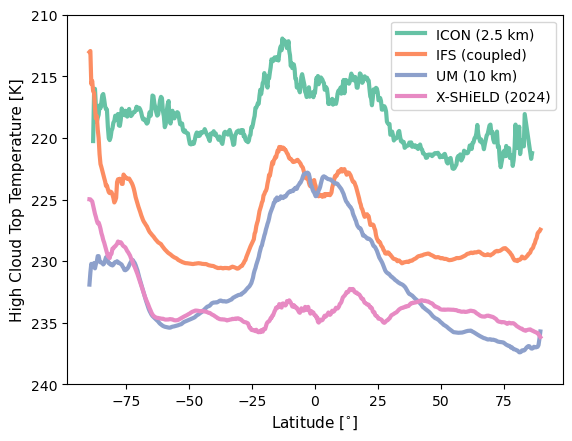

In [45]:
plt.plot(icon_latprof.lat, icon_latprof.CTT.data, c = cmap(0), linewidth = 3)
plt.plot(ifs_latprof.lat, ifs_latprof.CTT.data, c = cmap(1), linewidth = 3)
plt.plot(um_latprof.lat, um_latprof.CTT.data, c = cmap(2), linewidth = 3)
plt.plot(xshield_latprof.lat, xshield_latprof.CTT.data, c = cmap(3), linewidth = 3)
plt.ylim([240, 210])
plt.xlabel(r"Latitude [$^{\circ}$]", fontsize=11)
plt.ylabel(r"High Cloud Top Temperature [K]", fontsize=11)
plt.legend(['ICON (2.5 km)', 'IFS (coupled)', 'UM (10 km)', 'X-SHiELD (2024)'])
plt.savefig('CTT_means.png', dpi = 100)
plt.show()